## Introduction
This tutorial shows how to use tensorflow to train a neural network to mimic the $\neg (x_1 \oplus x_2)$ function. This function, abbreviated as XNOR, returns 1 only if $x_1$ is equal to $x_2$. The values are summarized in the table below:

$$
\begin{array}{c|c|c}
x_1 & x_2 & y \\ \hline
0 & 0 & 1 \\
0 & 1 & 0 \\
1 & 0 & 0 \\
1 & 1 & 1 \\
\end{array}
$$

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d

%matplotlib inline

In [2]:
def CreateLayer(X, width):
    W = tf.get_variable("W", [X.get_shape()[1].value, width], tf.float32)
    b = tf.get_variable("b", [width], tf.float32)
    return tf.nn.sigmoid(tf.add(tf.matmul(X, W), b))

def CreateTrainigOp(model, learning_rate, labels):
    loss_op = tf.reduce_mean(tf.square(tf.subtract(model, labels)))
    train_op = tf.train.AdamOptimizer(learning_rate).minimize(loss_op)
    return train_op, loss_op

In [3]:
def PlotValues(span, vals):
    fig = plt.figure(figsize=(10, 8))
    xv, yv = np.meshgrid(span, span)
    ax = fig.gca(projection='3d')
    cset = ax.contourf(xv, yv, vals, zdir='z', offset=span.min() - 0.3, cmap=cm.coolwarm)
    cset = ax.contourf(xv, yv, vals, zdir='x', offset=span.min() - 0.1, cmap=cm.coolwarm)
    cset = ax.contourf(xv, yv, vals, zdir='y', offset=span.max() + 0.1, cmap=cm.coolwarm)
    ax.plot_surface(xv, yv, vals, cmap=cm.coolwarm)

    ax.set_xlabel('x1')
    ax.set_xlim(span.min() - 0.1, span.max())
    ax.set_ylabel('y1')
    ax.set_ylim(span.min(), span.max() + 0.1)
    ax.set_zlabel('h')
    ax.set_zlim(span.min() - 0.3, span.max() + 0.1)

    plt.show()

In [9]:
# The input on which NN is trained. For, say [0, 0], we expect the NN to
# output something close to [1], etc.
X_train = np.array([[0, 0], [0, 1], [1, 0], [1, 1],])
y_train = np.array([[1], [0], [0], [1]])
    
# We reset the default graph to allow tf.get_variable run successfully every
# time this cell is run. Otherwise, it complains about existing variables.
tf.reset_default_graph()
sess = tf.Session()

# The summary writer is going to be used to trace loss, output from the first
# layer (z0) and output from the second layer (z1)
writer = tf.summary.FileWriter("/tmp/xnor_summary")

# Placeholders are fed data from the outside
X = tf.placeholder(tf.float32, [None, 2], name="X")
y = tf.placeholder(tf.float32, [None, 1], name="y")
# A neural network consisting of two layers. The first layer
# takex X, multiplies by weights W, adds biases b and applies
# sigmoid function to produce z0. This is repeated for layer 2
# except now z0 plays the role of the input. We use variable
# scope to make weights and biases for both layers unique.
with tf.variable_scope("layer1"):
    z0 = CreateLayer(X, 2)
    tf.summary.histogram("z0", z0)
with tf.variable_scope("layer2"):
    z1 = CreateLayer(z0, 1)
    tf.summary.histogram("z1", z1)
with tf.variable_scope("xnor"):
    training_op, loss_op = CreateTrainigOp(z1, 0.03, y_train)
    tf.summary.scalar("loss", loss_op)
 
writer.add_graph(sess.graph)
summ = tf.summary.merge_all()
sess.run(tf.global_variables_initializer())
saver = tf.train.Saver()
for step in xrange(5000):
    feed_dict = {X: X_train, y: y_train}
    sess.run(training_op, feed_dict=feed_dict)
    if step % 10 == 0:
        loss_trace.append(sess.run(loss_op, feed_dict=feed_dict))
        writer.add_summary(sess.run(summ, feed_dict=feed_dict), step)
save_path = saver.save(sess, '/tmp/xnor.ckpt')
sess.close()

In [10]:
# Once the model is trained we evaluate it on 20 x 20 points in the
# [0, 1] x [0, 1] linear space. These are used to plot the overall
# shape of surface generated by the neural net. Furthermore we print
# a table of corner values (0, 0), (0, 1), (1, 0) and (1, 1)
xnor_vals = []
span = np.linspace(0, 1, 20)
with tf.variable_scope("layer1", reuse=True):
    z0 = CreateLayer(X, 2)
with tf.variable_scope("layer2", reuse=True):
    z1 = CreateLayer(z0, 1)
with tf.variable_scope("xnor", reuse=True):
    training_op, loss_op = CreateTrainigOp(z1, 0.03, y_train)
with tf.Session() as sess:
    saver.restore(sess, "/tmp/xnor.ckpt")
    x1, x2 = np.meshgrid(span, span)
    X_in = np.column_stack([x1.flatten(), x2.flatten()])
    xnor_vals = np.reshape(sess.run(z1, feed_dict={X: X_in}), x1.shape)

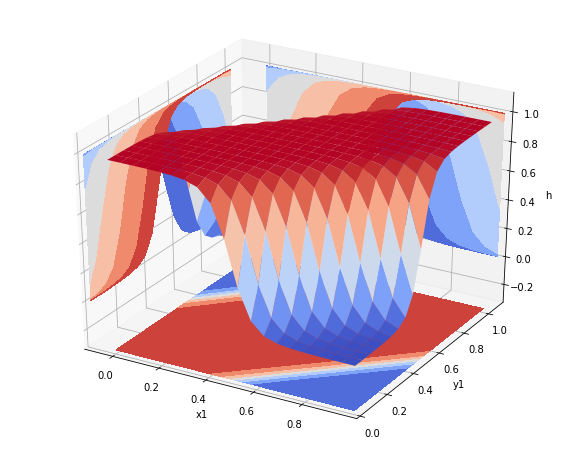

In [11]:
PlotValues(span, xnor_vals)

In [12]:
print " x1| x2| XNOR"
print "---+---+------"
print " 0 | 0 | %.3f" % xnor_vals[0][0]
print " 0 | 1 | %.3f" % xnor_vals[0][-1]
print " 1 | 0 | %.3f" % xnor_vals[-1][0]
print " 1 | 1 | %.3f" % xnor_vals[-1][-1]

 x1| x2| XNOR
---+---+------
 0 | 0 | 0.994
 0 | 1 | 0.007
 1 | 0 | 0.005
 1 | 1 | 0.995
